In [4]:
%pylab inline
import matplotlib.pylab

Populating the interactive namespace from numpy and matplotlib


In [5]:
from collections import Counter
import json
import pickle
import re
import gzip
import importlib
import datetime as dt
import numpy as np
import pandas as pd
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

pd.options.display.max_colwidth = 200

In [201]:
pd.__version__, sklearn.__version__

('0.19.1', '0.18.1')

In [6]:
import relevancer as rlv
rr = rlv.Relevancer(lang="nl")

ImportError: No module named 'relevancer'

# Read & Explore the JSON tweets

In [ ]:
tweets = rr.read_json_tweets_file("tweets_griep.json")

In [23]:
tweets[0]

{'coordinates': None,
 'created_at': datetime.datetime(2012, 12, 6, 22, 59, 53),
 'device': 'Twitter for iPhone',
 'entity_hashtags': ['griep'],
 'entity_mentions': [],
 'entity_urls': [],
 'id_str': '276823303736410112',
 'in_reply_to_user_id': None,
 'is_retweet': False,
 'screen_name': 'manon__klein',
 'text': 'Is de koorts eindelijk weg, komen de hoestbuien.... #griep',
 'user_followers': 82,
 'user_following': 201,
 'user_id': '237384795',
 'user_loc': '',
 'user_tzone': 'Amsterdam'}

In [22]:
tweets_df = rr.create_dataframe(tweets)
tweets_df["tweet_count"] = 1
tweets_df.info()

Number of documents per languge: Counter({'NoLang': 188474, 'nl': 41020, 'de': 35, 'en': 33, 'da': 28, 'pl': 19, 'id': 18, 'no': 9, 'sv': 7, 'vi': 6, 'lv': 6, 'tl': 5, 'tr': 4, 'ht': 3, 'lt': 2, 'pt': 2, 'hu': 2, 'es': 2, 'fi': 1, 'is': 1, 'fr': 1, 'et': 1})
41020
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41020 entries, 2012-12-06 22:59:53 to 2013-06-30 21:41:57
Data columns (total 18 columns):
coordinates            1035 non-null object
country                1223 non-null object
device                 41020 non-null object
entity_hashtags        41020 non-null object
entity_mentions        41020 non-null object
entity_type            467 non-null object
entity_urls            41020 non-null object
id_str                 41020 non-null object
in_reply_to_user_id    11108 non-null float64
is_retweet             41020 non-null bool
screen_name            41020 non-null object
text                   41020 non-null object
user_followers         41020 non-null int64
user_followi

In [49]:
tweets_df.head(2)

,coordinates,country,device,entity_hashtags,entity_mentions,entity_type,entity_urls,id_str,in_reply_to_user_id,is_retweet,screen_name,text,user_followers,user_following,user_id,user_loc,user_tzone,tweet_count
created_at,,,,,,,,,,,,,,,,,,
2013-01-01 00:04:41,None,NaN,Twitter for BlackBerry®,[],[],NaN,[],285899310338547712,NaN,False,LipglossaRoosje,Jammer genoeg muh griep :'( :'( liet t niet toe overstr te zijn zo n owru yari :(,134,145,408489847,,Santiago,1
2013-01-01 00:11:54,None,NaN,Twitter for Android,[],[],NaN,[],285901122747637760,NaN,False,rswierts,Zo en dan nu een week lang handen schudden. Extra aantrekkelijk omdat half NL griep heeft.,44,54,176923354,meestal ergens in de benelux.,Amsterdam,1


In [50]:
tweets_df.country.value_counts()

Nederland          423
The Netherlands    244
België              36
Belgium             22
Niederlande          4
France               2
Spanje               1
Noorwegen            1
United States        1
Germany              1
Name: country, dtype: int64

In [52]:
tweets_df.user_tzone.value_counts()[:5]

Amsterdam    11732
Greenland     3069
Athens        1808
Brussels       685
Hawaii         581
Name: user_tzone, dtype: int64

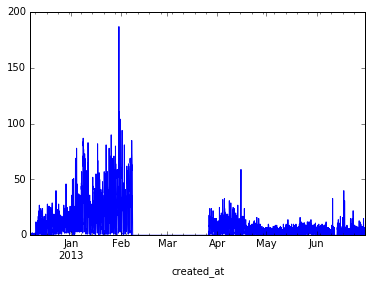

In [26]:
tweets_df.tweet_count.resample('1H').sum().fillna(0).plot()

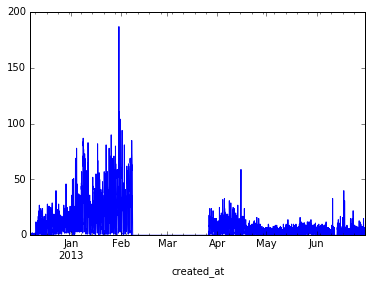

In [41]:
tweets_df.tweet_count.resample('1H').sum().fillna(0).plot()

In [42]:
tweets_df = tweets_df['2013-01-01 00:00':'2013-02-10 00:00']

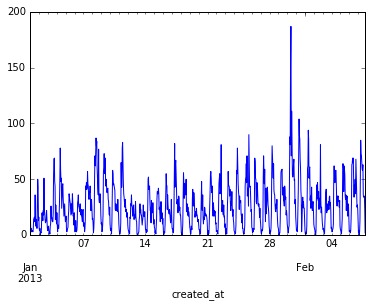

In [43]:
tweets_df.tweet_count.resample('1H').sum().fillna(0).plot()

In [57]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24260 entries, 2013-01-01 00:04:41 to 2013-02-07 19:08:30
Data columns (total 18 columns):
coordinates            616 non-null object
country                735 non-null object
device                 24260 non-null object
entity_hashtags        24260 non-null object
entity_mentions        24260 non-null object
entity_type            235 non-null object
entity_urls            24260 non-null object
id_str                 24260 non-null object
in_reply_to_user_id    6205 non-null float64
is_retweet             24260 non-null bool
screen_name            24260 non-null object
text                   24260 non-null object
user_followers         24260 non-null int64
user_following         24260 non-null int64
user_id                24260 non-null object
user_loc               24260 non-null object
user_tzone             18430 non-null object
tweet_count            24260 non-null int64
dtypes: bool(1), float64(1), int64(3), object(13)
memory 

In [53]:
uloc_grps = tweets_df.groupby("user_loc").size()
uloc_grps.sort_values(ascending=False).head(10)#[490:]

user_loc
                   7384
Nederland           666
Amsterdam           575
Netherlands         419
The Netherlands     323
Utrecht             247
Rotterdam           231
Groningen           161
Belgium             133
Eindhoven           111
dtype: int64

In [48]:
print(uloc_grps.sort_values(ascending=False).head(50).index.tolist())

['', 'Nederland', 'Amsterdam', 'Netherlands', 'The Netherlands', 'Utrecht', 'Rotterdam', 'Groningen', 'Belgium', 'Eindhoven', 'Nijmegen', 'Haarlem', 'nederland', 'Zwolle', 'Holland', 'Den Haag', 'Amersfoort', 'Tilburg', 'Almere', 'Hilversum', 'Enschede', 'Leeuwarden', 'Arnhem', 'Breda', 'NL', 'Zoetermeer', 'Bornem/België', 'amsterdam', 'Utrecht, The Netherlands', "'s-Hertogenbosch", 'Apeldoorn', 'the netherlands', 'Deventer', 'Assen', 'Alphen aan den Rijn', 'Maastricht', 'Zevenaar', 'Sneek', 'Dordrecht', 'netherlands', 'Leiden', 'Drenthe', 'Gouda', 'the Netherlands', 'Friesland', 'Meppel', 'Doetinchem', 'Alkmaar', 'Ede', 'Zeist']


In [202]:
tzone_grps = tweets_df.groupby("user_tzone").size()
tzone_grps.sort_values(ascending=False).head(10)#[20:50]

user_tzone
Amsterdam              10813
Greenland               2867
Athens                  1614
Brussels                 631
Hawaii                   531
Paris                     75
Berlin                    58
London                    52
West Central Africa       33
Santiago                  32
dtype: int64

In [54]:
screen_name_grps = tweets_df.groupby("screen_name").size()
screen_name_grps.sort_values(ascending=False).head(10)

screen_name
francois580       46
varkens_griep     39
griepheadlines    37
xchloe0172        24
vester71          23
Emiraten1975      22
NuGriep           22
Griepradar        21
nieuwsheadline    21
Rider_ot_Storm    19
dtype: int64

In [55]:
country_grps = tweets_df.groupby("country").size()
country_grps.sort_values(ascending=False).head(10)

country
Nederland          423
The Netherlands    244
België              36
Belgium             22
Niederlande          4
France               2
United States        1
Spanje               1
Noorwegen            1
Germany              1
dtype: int64

In [96]:
tweets_df.device.value_counts()[:20]

Twitter for Android          4995
Twitter for iPhone           4445
web                          3611
Twitter for BlackBerry®      1710
TweetDeck                    1478
Twitter for iPad             1225
UberSocial for BlackBerry     569
twitterfeed                   424
Echofon                       422
HootSuite                     350
Tweetbot for iOS              334
Facebook                      301
Tweet Button                  277
TweetCaster for Android       246
Mobile Web (M5)               159
Mobile Web (M2)               158
Twitter for Mac               115
UberSocial for Android        105
Twitterrific                   73
dlvr.it                        65
Name: device, dtype: int64

# Select a Date Range

In [58]:
myindex = pd.date_range('20130101 00:00','20130207 23:59', freq='2D')

In [204]:
for mi in myindex:
    print(mi, end=',')

2013-01-01 00:00:00,2013-01-03 00:00:00,2013-01-05 00:00:00,2013-01-07 00:00:00,2013-01-09 00:00:00,2013-01-11 00:00:00,2013-01-13 00:00:00,2013-01-15 00:00:00,2013-01-17 00:00:00,2013-01-19 00:00:00,2013-01-21 00:00:00,2013-01-23 00:00:00,2013-01-25 00:00:00,2013-01-27 00:00:00,2013-01-29 00:00:00,2013-01-31 00:00:00,2013-02-02 00:00:00,2013-02-04 00:00:00,2013-02-06 00:00:00,

In [60]:
tweets_df.sort_index(inplace=True)

In [61]:
tweets_df.index.max(), tweets_df.index.min()

(Timestamp('2013-02-07 19:08:30'), Timestamp('2013-01-01 00:04:41'))

In [67]:
delta = dt.timedelta(days=2)
number_of_days = (tweets_df.index.max() - tweets_df.index.min())/np.timedelta64(1, "2D")
number_of_days = int(number_of_days)+1
start = tweets_df.index[0]
end = tweets_df.index[0] + delta
rngs = []
for i in range(number_of_days):
        #print(start, ",", end)
        rngs.append((start, end))
        start = end
        end = end + delta

In [69]:
rngs

[(Timestamp('2013-01-01 00:04:41'), Timestamp('2013-01-03 00:04:41')),
 (Timestamp('2013-01-03 00:04:41'), Timestamp('2013-01-05 00:04:41')),
 (Timestamp('2013-01-05 00:04:41'), Timestamp('2013-01-07 00:04:41')),
 (Timestamp('2013-01-07 00:04:41'), Timestamp('2013-01-09 00:04:41')),
 (Timestamp('2013-01-09 00:04:41'), Timestamp('2013-01-11 00:04:41')),
 (Timestamp('2013-01-11 00:04:41'), Timestamp('2013-01-13 00:04:41')),
 (Timestamp('2013-01-13 00:04:41'), Timestamp('2013-01-15 00:04:41')),
 (Timestamp('2013-01-15 00:04:41'), Timestamp('2013-01-17 00:04:41')),
 (Timestamp('2013-01-17 00:04:41'), Timestamp('2013-01-19 00:04:41')),
 (Timestamp('2013-01-19 00:04:41'), Timestamp('2013-01-21 00:04:41')),
 (Timestamp('2013-01-21 00:04:41'), Timestamp('2013-01-23 00:04:41')),
 (Timestamp('2013-01-23 00:04:41'), Timestamp('2013-01-25 00:04:41')),
 (Timestamp('2013-01-25 00:04:41'), Timestamp('2013-01-27 00:04:41')),
 (Timestamp('2013-01-27 00:04:41'), Timestamp('2013-01-29 00:04:41')),
 (Time

In [203]:
for rs in rngs:
    print(tweets_df.ix[rs[0]:rs[1]].tweet_count.sum(), end=",")

499,1055,855,1600,1408,1010,818,936,1236,765,1114,1164,1272,1210,1730,1533,1043,1419,1457,

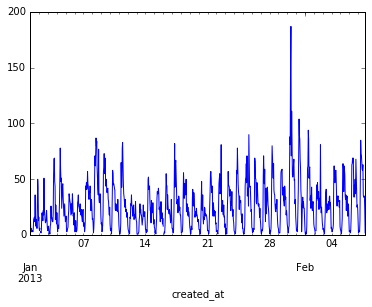

In [71]:
tweets_df.tweet_count.resample("H").sum().plot()

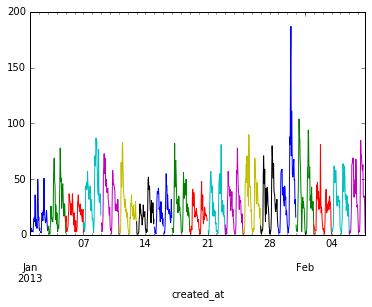

In [72]:
for rs in rngs:
    tweets_df.ix[rs[0]:rs[1]].tweet_count.resample("1H").sum().plot()

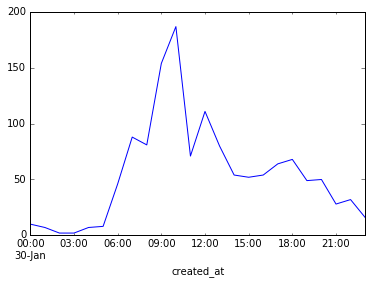

In [78]:
tweets_df["2013-01-30"].tweet_count.resample("1H").sum().plot()

In [83]:
tweets_df["2013-01-30 10"][["text"]][:3]

,text
created_at,
2013-01-30 10:00:12,"RT @feyenoordpings: Kamohelo #Mokotjo vervangt #Janmaat vanavond bij #psvFEY, die in Rotterdam achterblijft vanwege griep."
2013-01-30 10:00:16,"""@feyenoordpings: Kamohelo #Mokotjo vervangt #Janmaat vanavond bij #psvFEY, die in Rotterdam achterblijft vanwege griep."""
2013-01-30 10:00:16,"RT @feyenoordpings: Kamohelo #Mokotjo vervangt #Janmaat vanavond bij #psvFEY, die in Rotterdam achterblijft vanwege griep."


# Preprocess the Data

In [82]:
#tweets_df[rr.active_column] = tweets_df[rr.main_col].copy()
tweets_df = rr.transform_metatext(tweets_df)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24260 entries, 2013-01-01 00:04:41 to 2013-02-07 19:08:30
Data columns (total 19 columns):
coordinates            616 non-null object
country                735 non-null object
device                 24260 non-null object
entity_hashtags        24260 non-null object
entity_mentions        24260 non-null object
entity_type            235 non-null object
entity_urls            24260 non-null object
id_str                 24260 non-null object
in_reply_to_user_id    6205 non-null float64
is_retweet             24260 non-null bool
screen_name            24260 non-null object
text                   24260 non-null object
user_followers         24260 non-null int64
user_following         24260 non-null int64
user_id                24260 non-null object
user_loc               24260 non-null object
user_tzone             18430 non-null object
tweet_count            24260 non-null int64
text_active            24260 non-null object
dtypes: bool

In [86]:
tweets_df[["text","text_active"]][5:10]

,text,text_active
created_at,,
2013-01-01 00:15:46,"RT @KapotGrappig: Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ...","RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ..."
2013-01-01 00:15:48,"RT @KapotGrappig: Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ...","RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ..."
2013-01-01 00:16:11,"RT @KapotGrappig: Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ...","RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ..."
2013-01-01 00:16:13,"RT @KapotGrappig: Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ...","RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ..."
2013-01-01 00:16:32,"RT @KapotGrappig: Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ...","RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ..."


In [87]:
tweets_df[tweets_df.text.str.contains("\&amp;")][["text", rr.active_column]][:2]

,text,text_active
created_at,,
2013-01-01 04:20:07,Was echt weer een geweldig oud&amp;nieuw ondanks de griep toch een geslaagde dag!! Op naar volgend jaar!! #LetsGetIt #Vuurwerk #Plansfor2013,Was echt weer een geweldig oud&nieuw ondanks de griep toch een geslaagde dag!! Op naar volgend jaar!! #LetsGetIt #Vuurwerk #Plansfor2013
2013-01-01 21:10:53,"RT @anandjansen: Please RT! Iemand morgen naar Parijs voor 2 nachten?! Ik lig met zware griep in bed :( hotel incl P&amp;ontbijt, 100m n ...","RT usrusr Please RT! Iemand morgen naar Parijs voor 2 nachten?! Ik lig met zware griep in bed :( hotel incl P&ontbijt, 100m n ..."


In [93]:
tweets_df[rr.active_column].value_counts()#[20:40]

RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes de Griep. #Droge_ ...         57
RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt…. Groetjes, de Griep. #Slech ...           55
RT usrusr Please RT! Iemand morgen naar Parijs voor 2 nachten?! Ik lig met zware griep in bed :( hotel incl P&ontbijt, 100m n ...           46
RT usrusr Oke ik heb de griep. Bedankt Nederlands kut klimaat                                                                               42
RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt…. Groetjes, de Griep. #topmoppen           41
bestziek\nGriep. Op de een of andere manier slaat het bij mannen altijd harder toe. Soort virale mutatie. #bestziek                         41
RT usrusr Griep is bij mannen écht heftiger dan bij vrouwen - urlurl                                                                        41

In [94]:
print(len(tweets_df))
tweets_df.drop_duplicates(subset=[rr.active_column], inplace=True)
print(len(tweets_df))

24260
22126


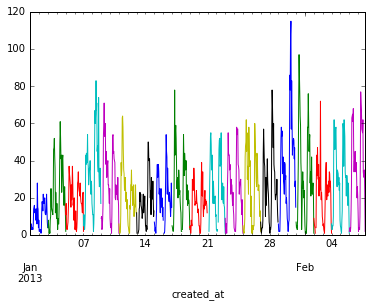

In [95]:
for rs in rngs:
    tweets_df.ix[rs[0]:rs[1]].tweet_count.resample("1H").sum().plot()

In [97]:
tweets_df_back_up = tweets_df.copy()
#tweets_df = tweets_df_back_up.copy()

In [98]:
print(*list(tweets_df.text.sort_values().values)[:10], sep="\n")

" @InaStrating: Grip op Griep... #hoedoejedat? " Door je er aan over te geven. #somsisdeoplossinghetprobleem
" Ik kan niet eens goed lachen......stont griep x_x"
" Is het hip om de griep te hebben?"
"1500 op de 100.000 Nederlanders hebben griep" http://t.co/tIfKnIlb Hopelijk zit ik daar niet bij,.!
"@Aaaamyxx: Koorts , spierpijn ,misselijk en knallende koppijn dankje griep dat je ook mij te pakken hebt !" Sterkte meis.. xx
"@AngelicaVanSon: Ojee ik hoop ni dat ik hier iedereen mijn griep geef. Ligt dadelijk iedereen plat." Thanks muppet
"@AnnelotteEsmee: 3e dag ziek en nog steeds geen verbetering.. kut griep" beterschap
"@ArjenHolleman: Zo appotheek. Spul wat de griep onderdrukt halen"stel je niet zo aan man..
"@Beetjeobsessief: Nou de romantiek is om te snijden hier. Het moet even. Tot over 5 minuten." #Joepie #begentle #griep
"@BlondeBosua_: Ziekjes .. Heb de griep te pakken :(((((((" beterschap nichiee


In [99]:
tweets_df = rr.remove_text_parts(tweets_df)

No defined text parts to be removed for: nl
Only language independent normalisation will take place.


In [102]:
print(*list(tweets_df[rr.active_column].sort_values().values)[:10], sep="\n")

# De griep heeft mij te pakken!!!! Deze week vervallen helaas alle Fighting4Power trainingen.
#114 op de #100000 mensen heeft griep. Dus #epidemie is niet afgezwakt maar #heviger
#2009, #WeetUNog? Toen we allemaal bijna dood waren door de Mexicaanse griep. Dat was nog een eng. #vroeger
#24kitchen kijken al heb ik totaal geen honger #griep
#3jstotzover aan en rustig aan doen nog niet helemaal herstelt #griep
#AD: Griep komt vroeg dit jaar. Dus, elke dag later beginnen en je hebt er geen last van.
#AanDeWCGekluistert door mijn #griep
#BalNieuws Janmaat door griep niet tegen PSV: Daryl Janmaat moet het bekertreffen met PSV laten schieten. De rec... urlurl
#Bluemonday of niet, maar ik zit met een fikse griep opgezadeld! :-( #flinkbalen
#Brussels Nieuws Aantal mensen met griep blijft stijgen - Nieuwsblad: Aantal mensen met griep blijft stijgenNieu... urlurl


In [103]:
tweets_df[["text", rr.active_column]][15:20]

,text,text_active
created_at,,
2013-01-01 03:14:27,"Al 35 uur niet gegeten. Ik ben zooo misselijk, maar heb ook zooo'n honger... Maar ik durf nog geen boterham te eten. #dilemma #griep","Al 35 uur niet gegeten. Ik ben zooo misselijk, maar heb ook zooo'n honger... Maar ik durf nog geen boterham te eten. #dilemma #griep"
2013-01-01 03:19:33,K heb gehoort van @QVDM__ dat je dan griep krijgt,K heb gehoort van usrusr dat je dan griep krijgt
2013-01-01 03:51:37,Het ia dus 10 viir 5 en wij zitten met griep aan het bier #ilike,Het ia dus 10 viir 5 en wij zitten met griep aan het bier #ilike
2013-01-01 03:52:55,"blij dat we toch maar zijn gegaan om half 5,want mn beste vriendinnetje heeft de griep:(. voor de rest super avond +nacht gehad!","blij dat we toch maar zijn gegaan om half 5,want mn beste vriendinnetje heeft de griep:(. voor de rest super avond +nacht gehad"
2013-01-01 03:53:55,"Nadat ik mensen heb thuis gebracht, helemaal zeiknat bn geregend en lekker gedoucht. Nu maar eens gaan slapen met vreselijke buikpijn #griep","Nadat ik mensen heb thuis gebracht, helemaal zeiknat bn geregend en lekker gedoucht. Nu maar eens gaan slapen met vreselijke buikpijn #griep"


In [175]:
print(*list(tweets_df[rr.active_column].sort_values().values)[:20], sep="\n")

# De griep heeft mij te pakken!!!! Deze week vervallen helaas alle Fighting4Power trainingen.
#114 op de #100000 mensen heeft griep. Dus #epidemie is niet afgezwakt maar #heviger
#2009, #WeetUNog? Toen we allemaal bijna dood waren door de Mexicaanse griep. Dat was nog een eng. #vroeger
#24kitchen kijken al heb ik totaal geen honger #griep
#3jstotzover aan en rustig aan doen nog niet helemaal herstelt #griep
#AD: Griep komt vroeg dit jaar. Dus, elke dag later beginnen en je hebt er geen last van.
#AanDeWCGekluistert door mijn #griep
#BalNieuws Janmaat door griep niet tegen PSV: Daryl Janmaat moet het bekertreffen met PSV laten schieten. De rec... urlurl
#Bluemonday of niet, maar ik zit met een fikse griep opgezadeld! :-( #flinkbalen
#Brussels Nieuws Aantal mensen met griep blijft stijgen - Nieuwsblad: Aantal mensen met griep blijft stijgenNieu... urlurl
#Cito, maanden spanning opgebouwd... Slaat de griep toe. Waarom toch zo'n eindtoets?
#Depri:Weer een winter van niks- giet-oan behalve 

In [105]:
tweets_df[tweets_df[rr.active_column].apply(lambda x: len(x)==0)][["text", rr.active_column]]

,text,text_active
created_at,,


In [106]:
print(len(tweets_df))
tweets_df = tweets_df[tweets_df[rr.active_column].apply(lambda x: len(x)>0)]
print(len(tweets_df))

22126
22126


In [110]:
tweets_df[tweets_df[rr.active_column].apply(lambda x: len(x.split())==1)][["text", rr.active_column]]

,text,text_active
created_at,,
2013-01-15 23:26:04,#Griep,#Griep
2013-01-22 08:00:25,Wakker#griep,Wakker#griep


In [111]:
print(len(tweets_df))
tweets_df = tweets_df[tweets_df[rr.active_column].apply(lambda x: len(x.split())>1)]
print(len(tweets_df))

22126
22124


In [112]:
tweets_df[tweets_df[rr.active_column].apply(lambda x: len(x.split())==1)][["text", rr.active_column]]

,text,text_active
created_at,,


In [113]:
tweets_df[tweets_df[rr.active_column].str.startswith("# ")]

,coordinates,country,device,entity_hashtags,entity_mentions,entity_type,entity_urls,id_str,in_reply_to_user_id,is_retweet,screen_name,text,user_followers,user_following,user_id,user_loc,user_tzone,tweet_count,text_active
created_at,,,,,,,,,,,,,,,,,,,
2013-01-30 12:39:26,None,NaN,web,[],[],NaN,[],296598496771993603,NaN,False,FIGHTING4POWER,# De griep heeft mij te pakken!!!! Deze week vervallen helaas alle Fighting4Power trainingen.,82,178,436918154,"The Netherlands, Utrecht",Amsterdam,1,# De griep heeft mij te pakken!!!! Deze week vervallen helaas alle Fighting4Power trainingen.


In [176]:
token_cntr = Counter()
i = 0
for txt, toks in zip(tweets_df[rr.active_column], tweets_df[rr.active_column].str.lower().str.findall(rr.my_token_pattern)):
    print(txt)
    print(toks)
    print()
    token_cntr.update(toks)
    i+=1
    if i == 10:
        break

Jammer genoeg muh griep :'( :'( liet t niet toe overstr te zijn zo n owru yari :(
['jammer', 'genoeg', 'muh', 'griep', 'liet', 't', 'niet', 'toe', 'overstr', 'te', 'zijn', 'zo', 'n', 'owru', 'yari']

Zo en dan nu een week lang handen schudden. Extra aantrekkelijk omdat half NL griep heeft.
['zo', 'en', 'dan', 'nu', 'een', 'week', 'lang', 'handen', 'schudden', 'extra', 'aantrekkelijk', 'omdat', 'half', 'nl', 'griep', 'heeft']

Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGrappig
['ik', 'kom', 'je', 'bezoeken', 'je', 'ligt', 'op', 'bed', 'ik', 'kom', 'in', 'je', 'je', 'gaat', 'trillen', 'en', 'zweten', 'je', 'kreunt', 'groetjes', 'de', 'griep', '#kapotgrappig']

RT usrusr Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGr ...
['rt', 'usrusr', 'ik', 'kom', 'je', 'bezoeken', 'je', 'ligt', 'op', 'bed', 'ik', 'kom', 'in', 'je', 'je', 'gaat', 'trillen', 'e

In [116]:
print(token_cntr.most_common(100))

[('griep', 79), ('de', 45), ('ik', 37), ('een', 34), ('en', 33), ('je', 30), ('usrusr', 30), ('het', 29), ('#griep', 22), ('niet', 20), ('maar', 19), ('in', 19), ('van', 18), ('jaar', 17), ('dat', 16), ('2013', 16), ('met', 16), ('nog', 14), ('is', 14), ('op', 13), ('te', 13), ('mijn', 12), ('nu', 11), ('voor', 11), ('die', 10), ('heb', 10), ('ook', 9), ('begin', 9), ('zo', 9), ('al', 8), ('bed', 8), ('naar', 8), ('heeft', 8), ('ziek', 8), ('zijn', 8), ('nieuwe', 7), ('dus', 7), ('ben', 7), ('kom', 7), ('echt', 7), ('lekker', 7), ('aan', 7), ('mij', 7), ('goed', 7), ('weer', 7), ('me', 7), ('door', 6), ('wel', 6), ('gaat', 6), ('er', 6), ('begint', 6), ('gehad', 6), ('ja', 6), ('iedereen', 6), ('gelukkig', 6), ('we', 6), ('n', 5), ('toch', 5), ('geen', 5), ('dit', 5), ('t', 5), ('beter', 5), ('wat', 5), ('kan', 4), ('dan', 4), ('niks', 4), ('om', 4), ('nieuwjaar', 4), ('als', 4), ('gezond', 4), ('nacht', 4), ('heel', 4), ('bezoeken', 4), ('andere', 4), ('was', 4), ('wakker', 4), ('af',

In [62]:
tweets_df[rr.active_column] = tweets_df[rr.active_column].str.lower()

# Cluster the Tweets

In [121]:
cluster_list_per_hour1 = []
for i, rs in enumerate(rngs):
    tweets_daterange = str(rs[0])+"_"+str(rs[1])
    print(i, tweets_daterange, len(tweets_df.ix[rs[0]:rs[1]]), end=", ")
    day_cluster_list = rr.create_clusters2(tweets_df.ix[rs[0]:rs[1]], rr.my_token_pattern, min_dist_thres=0.725, 
                                           max_dist_thres=0.875, min_max_diff_thres=0.4, nameprefix='1-', 
                                           min_clusters=50, user_identifier='user_id', myanalyzer='char_wb',
                                          ngramrange=(3,5))
    rr.cluster_to_text_file("201612.._griep_"+str(tweets_daterange)+"_clusters50_1.txt", day_cluster_list)
    cluster_list_per_hour1.append((tweets_daterange, day_cluster_list))

0 2013-01-01 00:04:41_2013-01-03 00:04:41 499, 1 2013-01-03 00:04:41_2013-01-05 00:04:41 1055, 2 2013-01-05 00:04:41_2013-01-07 00:04:41 855, 3 2013-01-07 00:04:41_2013-01-09 00:04:41 1600, 4 2013-01-09 00:04:41_2013-01-11 00:04:41 1408, 5 2013-01-11 00:04:41_2013-01-13 00:04:41 1010, 6 2013-01-13 00:04:41_2013-01-15 00:04:41 818, 7 2013-01-15 00:04:41_2013-01-17 00:04:41 936, 8 2013-01-17 00:04:41_2013-01-19 00:04:41 1236, 9 2013-01-19 00:04:41_2013-01-21 00:04:41 765, 10 2013-01-21 00:04:41_2013-01-23 00:04:41 1114, 11 2013-01-23 00:04:41_2013-01-25 00:04:41 1164, 12 2013-01-25 00:04:41_2013-01-27 00:04:41 1272, 13 2013-01-27 00:04:41_2013-01-29 00:04:41 1210, 14 2013-01-29 00:04:41_2013-01-31 00:04:41 1730, 15 2013-01-31 00:04:41_2013-02-02 00:04:41 1533, 16 2013-02-02 00:04:41_2013-02-04 00:04:41 1043, 17 2013-02-04 00:04:41_2013-02-06 00:04:41 1419, 18 2013-02-06 00:04:41_2013-02-08 00:04:41 1457, 

In [68]:
cluster_list_per_hour1[0][1][0].keys()

dict_keys(['cnoprefix', 'user_entropy', 'cno', 'rif', 'twids', 'cstr', 'ctweettuplelist'])

In [69]:
cluster_list_per_hour1[0][1][0]["cno"]

39

In [122]:
with open("2016121.._griep_hourly_clusters50_0.pickle", 'wb') as f:
    pickle.dump(cluster_list_per_hour1, f, pickle.HIGHEST_PROTOCOL)
# # with open("201611.._earthq_hourly_clusters50_0.pickle",'rb') as f:
# #     cluster_list_per_day = pickle.load(f)

In [123]:
clustered_ids = []
for dt, clst_day in cluster_list_per_hour1:
    for clst in clst_day:
        if clst["cno"] != -1:
            clustered_ids += clst["twids"]
len(clustered_ids), len(set(clustered_ids))

(8997, 8997)

In [124]:
len(tweets_df[tweets_df.id_str.isin(clustered_ids)]), len(tweets_df[~tweets_df.id_str.isin(clustered_ids)])

(8997, 13127)

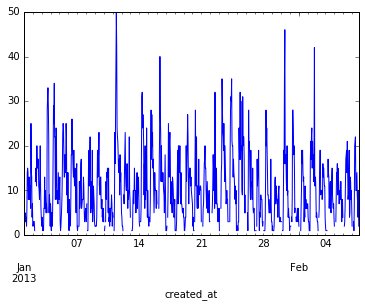

In [125]:
tweets_df[tweets_df.id_str.isin(clustered_ids)].tweet_count.resample("H").sum().plot()

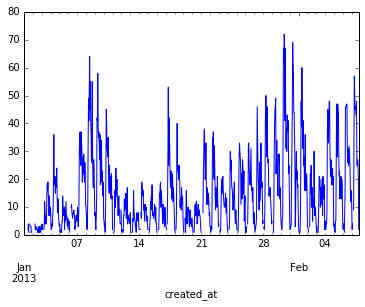

In [126]:
tweets_df[~tweets_df.id_str.isin(clustered_ids)].tweet_count.resample("H").sum().plot()

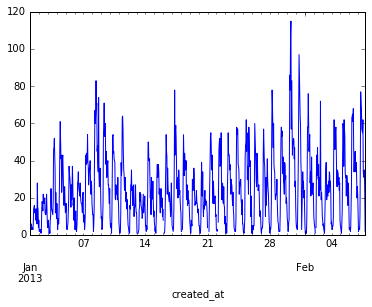

In [127]:
tweets_df.tweet_count.resample("H").sum().plot()

In [128]:
not_clustered_tweets_df = tweets_df[~tweets_df.id_str.isin(clustered_ids)]

In [129]:
cluster_list_2 = rr.create_clusters2(not_clustered_tweets_df, rr.my_token_pattern, min_dist_thres=0.725,
                                     max_dist_thres=0.875, min_max_diff_thres=0.4, nameprefix='1-', 
                                     min_clusters=50, user_identifier='user_id', myanalyzer='char_wb',
                                     ngramrange=(3,5))

In [131]:
rr.cluster_to_text_file("201612.._griep_clusters50_allafterHourly_0.txt", cluster_list_2)

In [132]:
with open("201612.._griep_2day_clusters50_allafterHourly_0.pickle", 'wb') as f:
    pickle.dump(cluster_list_2, f, pickle.HIGHEST_PROTOCOL)
# with open("20161.._earthq_hourly_clusters50_allafterdaily_0.pickle", 'rb') as f:
#     cluster_list_2 = pickle.load(f)
    #print(len(pickle.load(f)))

In [133]:
clustered_ids2 = []
for clst in cluster_list_2:
    if clst["cno"] != -1:
        clustered_ids2 += clst["twids"]

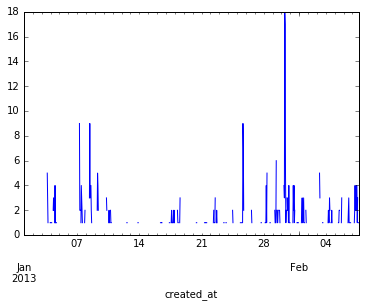

In [134]:
tweets_df[tweets_df.id_str.isin(clustered_ids2)].tweet_count.resample("H").sum().plot()

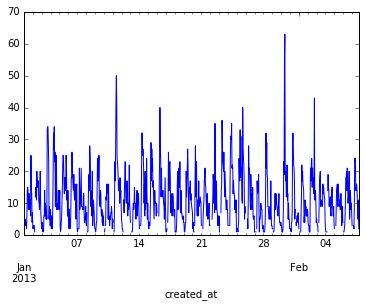

In [135]:
tweets_df[tweets_df.id_str.isin(clustered_ids+clustered_ids2)].tweet_count.resample("H").sum().plot()

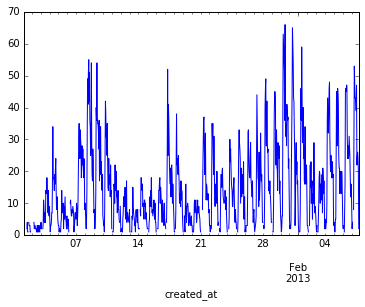

In [136]:
not_clustered_tweets_df2 = tweets_df[~tweets_df.id_str.isin(clustered_ids+clustered_ids2)]
not_clustered_tweets_df2.tweet_count.resample("H").sum().plot()

In [137]:
# uncomment just once to add cluster_list_2 to the list!
#cluster_list_per_hour1.append(("all_hours", cluster_list_2))

In [138]:
cluster_list_per_hour1[-1][0]

'all_hours'

In [139]:
flat_cluster_list = []
for clst in cluster_list_per_hour1:
    for c in clst[1]:
        if c["cno"] == -1:
            continue
        c["hour"] = clst[0]
        flat_cluster_list.append(c)

In [140]:
len(flat_cluster_list), flat_cluster_list[0].keys()

(1066,
 dict_keys(['rif', 'user_entropy', 'cnoprefix', 'cstr', 'hour', 'ctweettuplelist', 'cno', 'twids']))

In [141]:
rr.cluster_to_text_file("201612016_griep_hourly_clusters50_all_0.txt", flat_cluster_list)

In [146]:
# with open("20161216_griep_hourly_clusters50_all_0.pickle", 'wb') as f:
#     pickle.dump(flat_cluster_list, f, pickle.HIGHEST_PROTOCOL)

In [147]:
# Just in case back-up.
# with open("20161216_griep_hourly_clusters50_all_with_unclusteredIDs_0.pickle", 'wb') as f:
#     pickle.dump(cluster_list_per_hour1, f, pickle.HIGHEST_PROTOCOL)

In [143]:
# create a file for the annotation. You need it once! It overwrites any available file with the same name.
# with open("20161216_earthq_hourly_clusters50_all_0_labels.txt", "w") as f:
#     for i in range(0,len(flat_cluster_list)):
#         f.write(str(i)+":\n")

# Annotate

In [ ]:
Some explanation is provided in the presentation.

# Read Annotated clusters & Create a Classifier

In [154]:
with open("20161216_griep_hourly_clusters50_all_0_labels.txt") as f:
    file_content = [l.strip() for l in f.readlines()]
    order_label = {l.split(":")[0]:l.split(":")[1] for l in file_content}
    print(len(file_content), file_content, order_label)

1066 ['0:irrelevant', '1:goodwish', '2:ziekmelding', '3:ziekmelding', '4:ziekmelding', '5:incoherent', '6:news', '7:', '8:incoherent', '9:incoherent', '10:', '11:', '12:', '13:', '14:', '15:', '16:', '17:', '18:', '19:', '20:', '21:', '22:', '23:', '24:', '25:', '26:', '27:', '28:', '29:', '30:', '31:', '32:', '33:', '34:', '35:', '36:', '37:', '38:', '39:', '40:', '41:', '42:', '43:', '44:', '45:', '46:', '47:', '48:', '49:', '50:', '51:', '52:', '53:', '54:', '55:', '56:', '57:', '58:', '59:', '60:', '61:', '62:', '63:', '64:', '65:', '66:', '67:', '68:', '69:', '70:', '71:', '72:', '73:', '74:', '75:', '76:', '77:', '78:', '79:', '80:', '81:', '82:', '83:', '84:', '85:', '86:', '87:', '88:', '89:', '90:', '91:', '92:', '93:', '94:', '95:', '96:', '97:', '98:', '99:', '100:', '101:', '102:', '103:', '104:', '105:', '106:', '107:', '108:', '109:', '110:', '111:', '112:', '113:', '114:', '115:', '116:', '117:', '118:', '119:', '120:', '121:', '122:', '123:', '124:', '125:', '126:', '12

In [148]:
with open("20161216_griep_hourly_clusters50_all_0.pickle", 'rb') as f:
    my_cluster_list = pickle.load(f)
len(my_cluster_list)

1066

In [155]:
# attach labels to the clusters.
labeled_cluster_list = []
for i,c in enumerate(my_cluster_list):
    my_cluster_list[i]["label"] = order_label[str(i)]
    
    if len(my_cluster_list[i]["label"])>0:
        labeled_cluster_list.append(my_cluster_list[i])
len(labeled_cluster_list)

9

In [156]:
my_cluster_list[1]["label"]

'goodwish'

In [163]:
total_len_label_tweets = 0
for c in [e["ctweettuplelist"] for e in labeled_cluster_list if e["label"]=='incoherent']:
    label_tweets = [t[2] for t in c]
    total_len_label_tweets += len(label_tweets)
    print(*label_tweets, sep="\n*")

er zijn heel veel mensen ziek; griep................
*Stem weg, griep en thuis moeten blijven ..........
*Naar bed maar weer.......# griep#
*Hoe verlies je in 4 dagen bijna 5 kilo.......zware griep krijgen....man #hondsberoerd.
*niks gevierd gister.....griep....2013..LDL
*Oud en nieuw goed begonnen!!......met de griep!! Whoepiedoo
*usrusr Dan moet het een wanhopige griep zijn geweest om wodka te gaan drinken. #ofalldrinks......
*usrusr Oké, oké, ik blijf waar ik ben....in bed.... #griep
*usrusr *verstikt sprekend* Neee m'n keel zit dicht, neus loopt en.....gvd zou 't de griep zijn...
Ben ik eindelijk opgeknapt, begint die klote griep weer
*Eindelijk weer op werk, take that griep
*zo... de #griep is eindelijk verdreven uit huize Van Houten. Wij kunnen er weer volop tegenaan
*usrusr zeker. Rustig an. eindelijk van die verdomde griep af. Flink stuk hardgelopen. Voel me weer fit. En jij...?
*Bing gaat uiteindelijk dood aan de bacterien van de griep van Lana ! #gtst
*Net proefondervindelijk

In [160]:
total_len_label_tweets

23

In [164]:
label_cntr = Counter()
label_tweets_dict = {}
for c in [ec for ec in labeled_cluster_list]:
    label_cntr[c["label"]] += len(c['ctweettuplelist'])
    if c["label"] not in label_tweets_dict:
        label_tweets_dict[c["label"]] = []
    label_tweets_dict[c["label"]] += [tt[2] for tt in c['ctweettuplelist']]

label_cntr

Counter({'goodwish': 13,
         'incoherent': 23,
         'irrelevant': 13,
         'news': 15,
         'ziekmelding': 41})

In [165]:
label_tweet_tuple_list = []
for k,v in label_tweets_dict.items():
    label_tweet_tuple_list += [(k,vv) for vv in v]

In [166]:
labeled_tweets_df = pd.DataFrame({'label':[lab_tw[0] for lab_tw in label_tweet_tuple_list],'text':[lab_tw[1] for lab_tw in label_tweet_tuple_list]})
labeled_tweets_df.head(3)

,label,text
0,ziekmelding,"Griep is niet leuk man, vooral niet in de vakantie.."
1,ziekmelding,"usrusr Griep is niet leuk man, vooral niet in de vakantie.."
2,ziekmelding,"RT usrusr Griep is niet leuk man, vooral niet in de vakantie.."


In [167]:
labeled_tweets_df.label.value_counts()

ziekmelding    41
incoherent     23
news           15
irrelevant     13
goodwish       13
Name: label, dtype: int64

In [168]:
tweets_df_selected = labeled_tweets_df[labeled_tweets_df.label != 'incoherent']#["label"].value_counts()

In [170]:
tweets_df_selected[tweets_df_selected.label == 'news'][:5]

,label,text
77,news,RT usrusr Nederland en Engeland grieperig het nieuwe jaar in urlurl #griep #influenza
78,news,"usrusr ""usrusr Nederland en Engeland grieperig het nieuwe jaar in urlurl #griep #influenza"
79,news,Nederland en Engeland grieperig het nieuwe jaar in urlurl #griep #influenza
80,news,RT usrusr Hogere dosis griep vaccin voor mensen met hiv? urlurl
81,news,Einde griep dan toch in zicht? Tijd voor aan een verse cappu! (usrusr Coffee United (Central Station)) [pic]: urlurl


In [3]:
vect_and_evaluated_classifier_nv, confm_nv, clf_report = rr.get_evaluated_classifier_cwb(tweets_df_selected, (1,3))

NameError: name 'rr' is not defined

In [190]:
tweets_df[rr.active_column].values

array([ "Jammer genoeg muh griep :'( :'( liet t niet toe overstr te zijn zo n owru yari :(",
       'Zo en dan nu een week lang handen schudden. Extra aantrekkelijk omdat half NL griep heeft.',
       'Ik kom je bezoeken, je ligt op bed, ik kom in je, je gaat trillen en zweten, je kreunt.... Groetjes, de Griep #KapotGrappig',
       ...,
       'hé gezellig... samen met de griep naar wie is de mol kijken.... #widm',
       'usrusr Wegens de griep deze week geen foto\'s of nieuws."Beterschap Ron.',
       "usrusr In een groot gezin duurt het dan best lang voordat zo'n griep het huis weer verlaten heeft"], dtype=object)

In [2]:
tweets_to_classify = ["Jammer genoeg muh griep :'( :'( liet t niet toe overstr te zijn zo n owru yari :("]
mnb_classifier = vect_and_evaluated_classifier_nv["classifier"]
vectorizer = vect_and_evaluated_classifier_nv["vectorizer"]
mnb_classifier.predict(vectorizer.transform(tweets_to_classify))

NameError: name 'vect_and_evaluated_classifier_nv' is not defined

In [197]:
print(vectorizer.get_feature_names())

['aan', 'aanwezig', 'advil', 'af', 'al', 'alles', 'alles sneller', 'alles sneller gaat', 'als', 'als een', 'altijd', 'begin', 'ben', 'ben nog', 'ben nog steeds', 'bestaat', 'bestaat echt', 'bestaat echt niet', 'beste', 'beterschap', 'beterschap en', 'bij', 'bijna', 'binnen', 'binnen minuut', 'binnen minuut over', 'da', 'dan', 'dat', 'dat in', 'dat in meerdijk', 'dat je', 'dat ze', 'de', 'de griep', 'de griep binnen', 'de griep is', 'de griep te', 'de vakantie', 'denk', 'deze', 'die', 'die griep', 'dikke', 'dit', 'door', 'door griep', 'echt', 'echt niet', 'echt niet gtst', 'een', 'en', 'en engeland', 'en engeland grieperig', 'en moe', 'en moe omg', 'en nu', 'en nu koorts', 'engeland', 'engeland grieperig', 'engeland grieperig het', 'er', 'erge', 'erge griep', 'erge griep vannochten', 'fijn', 'flauw', 'flauw gevallen', 'flauw gevallen en', 'ga', 'gaat', 'gaat maar', 'gaat maar de', 'geen', 'geen griep', 'geen griep ja', 'geen griep migraine', 'geen griep migranne', 'gevallen', 'gevallen 